# Imports

In [1]:
import math
import numpy as np
import pygad
import matplotlib.pyplot as plt
from plotting import *
from utils import is_layout_valid

from py_wake.site import UniformWeibullSite
from py_wake.site import XRSite
from py_wake.utils import weibull
import xarray as xr
from numpy import newaxis as na

from py_wake.wind_turbines.power_ct_functions import PowerCtFunction
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import NOJDeficit, BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum
from py_wake.rotor_avg_models import AreaOverlapAvgModel
# from py_wake.deficit_models import *
# from py_wake.deficit_models.deficit_model import *
# from py_wake.wind_farm_models import *
# from py_wake.deflection_models import *
# from py_wake.turbulence_models import *
# from py_wake.ground_models import *
# from py_wake.deficit_models.utils import *

from scipy.optimize import minimize
import logging
import itertools

from sklearn.base import BaseEstimator

In [2]:
def plot_multiple_layouts(layouts, title='', lim=None):
    plt.figure()
    for i, layout in enumerate(layouts):
        x_coordinates = [coord[0] for coord in layout]
        y_coordinates = [coord[1] for coord in layout]
        plt.scatter(x_coordinates, y_coordinates, marker='x', label=f'Layout {i+1}')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    if lim:
        plt.xlim(*lim[0])
        plt.ylim(*lim[1])
    plt.title('Layouts of Turbines' if not title else title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

# Problem parameters

In [3]:
n_turbines = 9
area_size = 2100
min_spacing = 300
wind_speed = 8.6
wind_direction = 300

# Model definition

## Site model

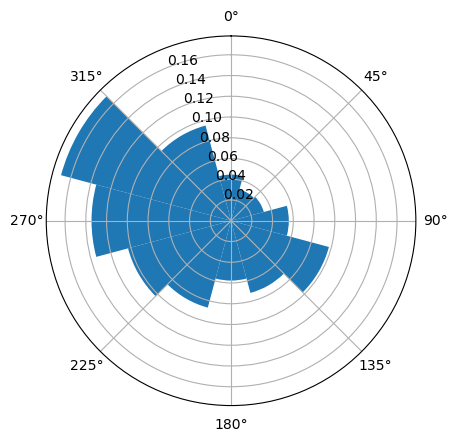

In [4]:
f = [0.04, 0.03, 0.03, 0.05, 0.11, 0.07, 0.05, 0.09, 0.1, 0.13, 0.19, 0.09]                      # sector frequencies
# A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]  # Weibull scale parameter
# k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]       # Weibull shape parameter
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1                                                                                        # turbulence intensity, optional

#wind_speeds = np.arange(3, 25, 1)

x_i, y_i = np.arange(n_turbines) * area_size/n_turbines, np.arange(n_turbines) * area_size/n_turbines
wt_positions = np.array([x_i, y_i]).T


# Site with constant wind speed, sector frequency, constant turbulence intensity
site = XRSite(
    ds=xr.Dataset(
        data_vars={'WS': wind_speed, 'P': ('wd', f), 'TI': ti},
        # data_vars={'Sector_frequency': ('wd', f), 'Weibull_A': ('wd', A), 'Weibull_k': ('wd', k), 'TI': ti},
        coords={'i': np.arange(n_turbines), 'wd': wd}),
    initial_position=wt_positions)

site.plot_wd_distribution(n_wd=12);

## Turbine model

In [5]:
def power_output(wind_speed):
    P_r = 3.00  # Rated turbine power output [MW]
    v_ci = 3.0  # Cut-in wind speed [m/s]
    v_r = 9.8  # Rated wind speed [m/s]
    v_co = 22.5  # Cut-out wind speed [m/s]

    if wind_speed < v_ci or wind_speed >= v_co:
        return 0
    elif wind_speed < v_r:
        return P_r * ((wind_speed - v_ci) / (v_r - v_ci)) ** 3
    else:
        return P_r

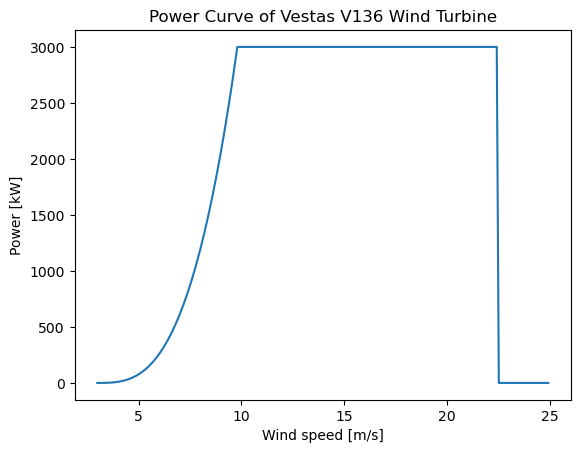

In [6]:
plt.figure()
ws = np.arange(3, 25, 0.1)
power_curve = np.array([power_output(w) for w in ws])
plt.plot(ws, power_curve * 1e3, label='Vestas V136')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
plt.title('Power Curve of Vestas V136 Wind Turbine');

In [7]:
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine


u = np.linspace(0, 30, 100)
power = np.array([power_output(w) for w in u])
ct = np.interp(u, [0, 3, 12, 25, 30], [0, 8/9, 8/9, 0.3, 0])

power_ct_function = PowerCtTabular(u, power, 'MW', ct)

wt = WindTurbine(name='WT',
                    diameter=136,
                    hub_height=122,
                    powerCtFunction=power_ct_function)

wind_turbines = WindTurbines.from_WindTurbine_lst([wt for _ in range(n_turbines)])
types = wind_turbines.types()
print ("Name:\t\t%s" % "\t".join(wind_turbines.name(types)))
print('Diameter[m]\t%s' % "\t".join(map(str,wind_turbines.diameter(type=types))))
print('Hubheigt[m]\t%s' % "\t".join(map(str,wind_turbines.hub_height(type=types))))

Name:		WT	WT	WT	WT	WT	WT	WT	WT	WT
Diameter[m]	136.0	136.0	136.0	136.0	136.0	136.0	136.0	136.0	136.0
Hubheigt[m]	122.0	122.0	122.0	122.0	122.0	122.0	122.0	122.0	122.0


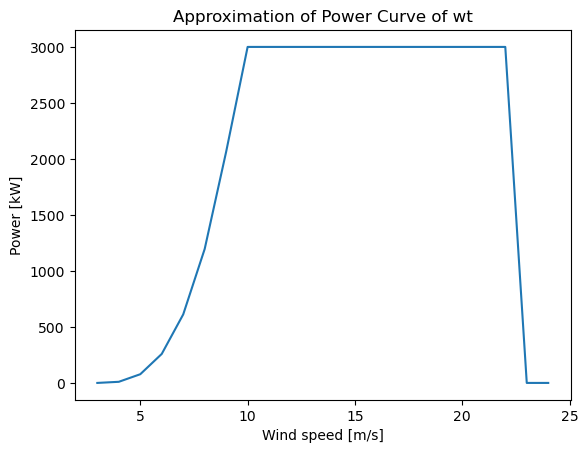

In [8]:
ws = np.arange(3,25)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
plt.plot(ws, wind_turbines.power(ws, type=0)*1e-3)
plt.title('Approximation of Power Curve of wt');

## Wake model

In [9]:
wake_model = PropagateDownwind(
                        site,
                        wind_turbines,
                        wake_deficitModel=NOJDeficit(  # BastankhahGaussianDeficit
                            k=0.1,
                            rotorAvgModel=AreaOverlapAvgModel(),
                            groundModel=None),
                        superpositionModel=LinearSum(),
                        deflectionModel=None,
                        turbulenceModel=None,
                        rotorAvgModel=None)

In [10]:
def plot_wt_positions(wt_x, wt_y, title=None):
    plt.figure()
    plt.axis([0, area_size, 0, area_size])
    wt.plot(wt_x, wt_y)
    if title:
        plt.title(title)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]');

# Wake map for a different wind directions

In [11]:
wt_x, wt_y = site.initial_position.T
wind_directions = np.linspace(0, 360, 12, endpoint=False)

In [12]:
def plot_wake_map(wt_x, wt_y):
    plt.figure(figsize=(6, 5))

    sim_res = wake_model(wt_x, wt_y, wd=[wind_direction], ws=wind_speed)
    aep = sim_res.aep().sum()
    flow_map = sim_res.flow_map().plot_wake_map()
    
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Wake map for'+ f' {wind_direction} deg and {wind_speed} m/s' + ", total AEP: %f MWh"% aep);

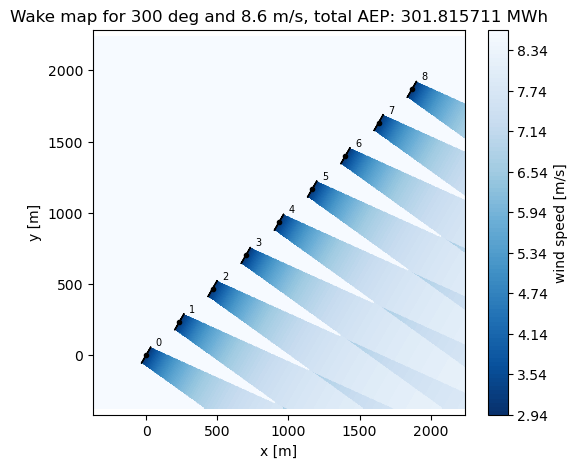

In [13]:
plot_wake_map(wt_x, wt_y)

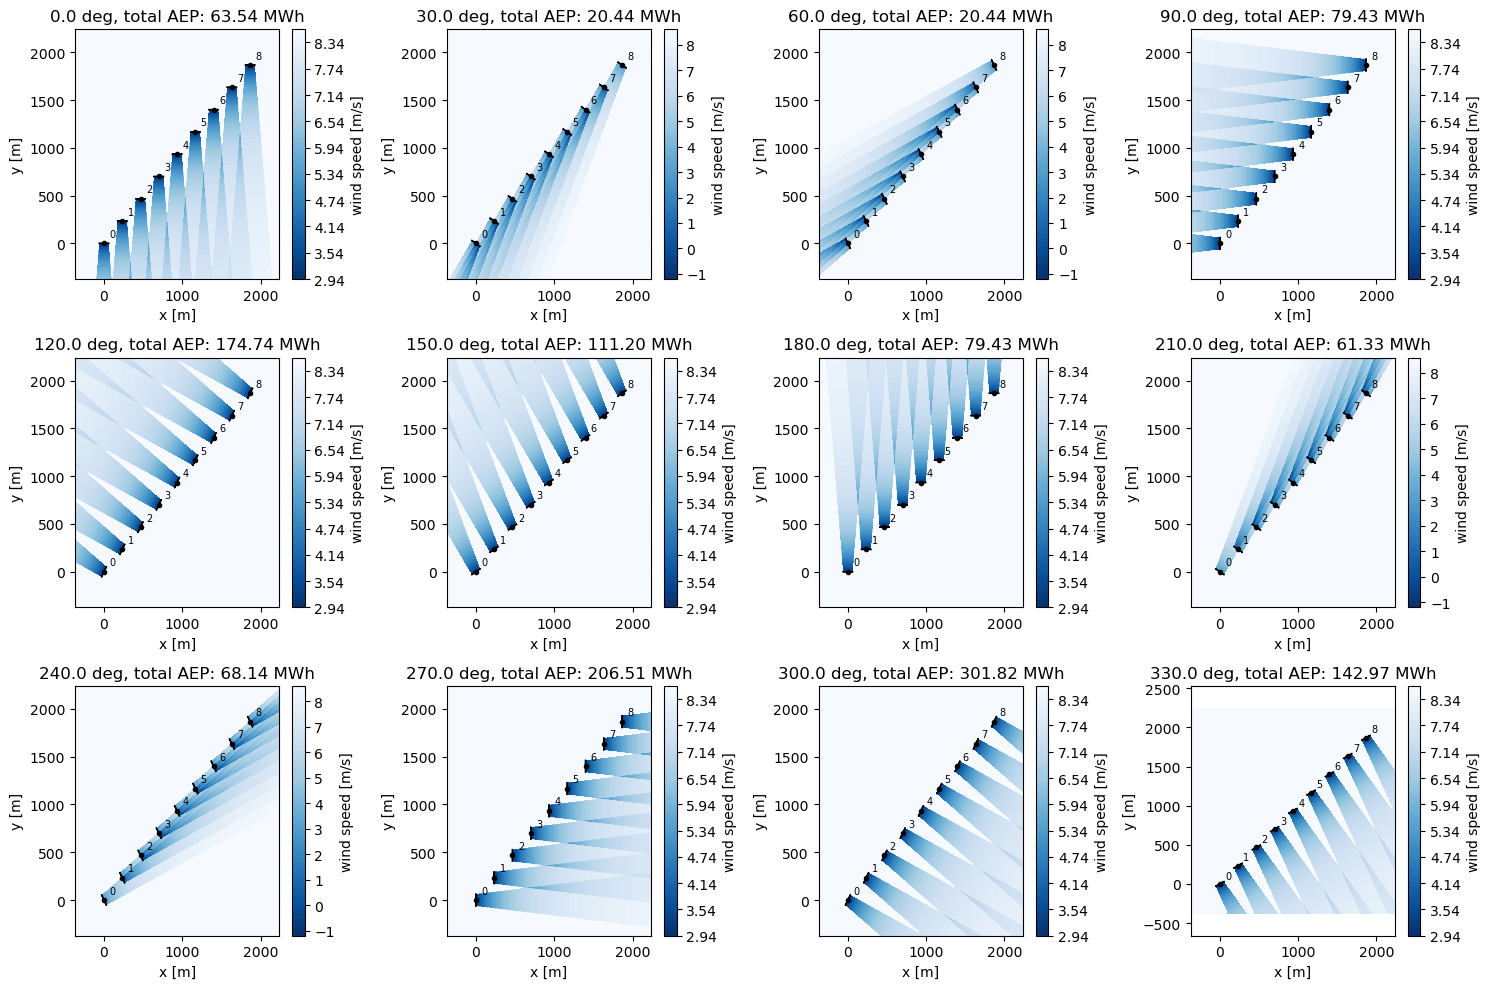

In [14]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()
for i, wd in enumerate(wind_directions):
    ax = axes[i]
    
    sim_res = wake_model(wt_x, wt_y, wd=[wd], ws=wind_speed)
    aep = sim_res.aep().sum()
    sim_res.flow_map().plot_wake_map(ax=ax)
    
    ax.set_title(f"{wd:.1f} deg" + ", total AEP: %.2f MWh"% aep)
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')

plt.tight_layout()
plt.show()

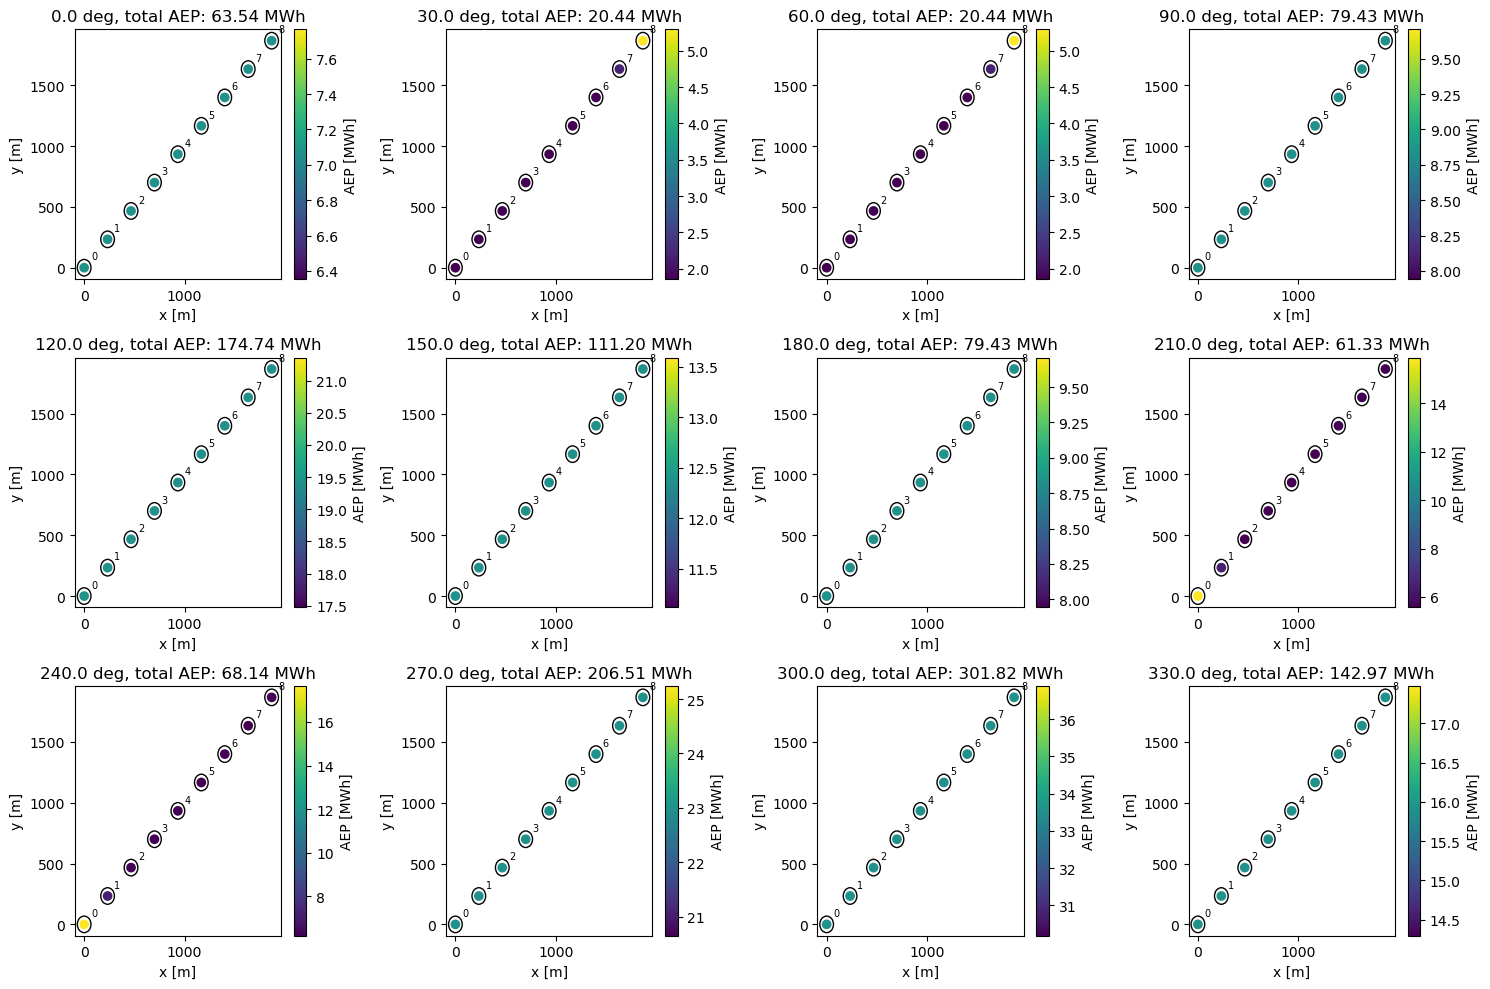

In [15]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()
for i, wd in enumerate(wind_directions):
    ax = axes[i]
    
    sim_res = wake_model(wt_x, wt_y, wd=[wd], ws=wind_speed)
    aep = sim_res.aep()
    wind_turbines.plot(wt_x, wt_y, ax=ax)
    c = ax.scatter(wt_x, wt_y, c=aep.sum(['wd', 'ws']))
    fig.colorbar(c, ax=ax, label='AEP [MWh]')
    
    ax.set_title(f"{wd:.1f} deg" + ", total AEP: %.2f MWh"% aep.sum())
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')

plt.tight_layout()
plt.show()

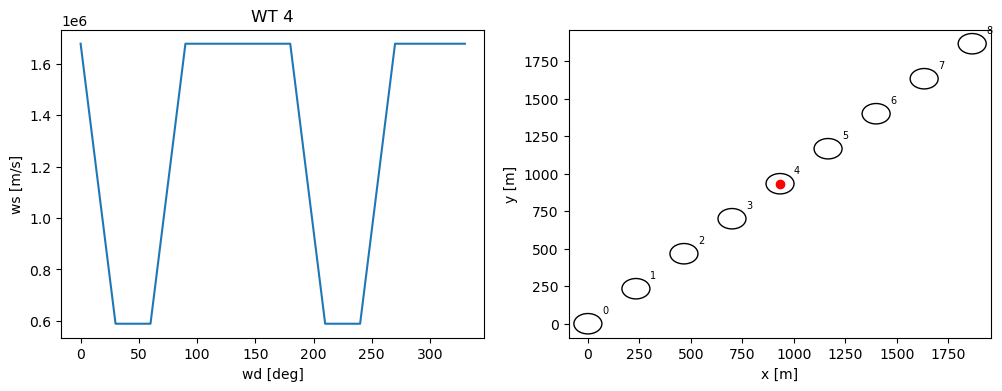

In [16]:
selected_turbine = 4
sim_res = wake_model(wt_x, wt_y, wd=wind_directions, ws=wind_speed)


ax1, ax2 = plt.subplots(1,2, figsize=(12,4))[1]
sim_res.Power.sel(wt=selected_turbine).T.plot(ax=ax1)
ax1.set_xlabel('wd [deg]')
ax1.set_ylabel('ws [m/s]')
ax1.set_title(f'WT {selected_turbine}')
wind_turbines.plot(wt_x, wt_y, ax=ax2)
ax2.plot(wt_x[selected_turbine], wt_y[selected_turbine],'or')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]');

# Metrics

In [17]:
def aep_percentage_change(init_total_aep, optimized_total_aep):
    return (optimized_total_aep - init_total_aep) / (init_total_aep + 1e-7, 2)

In [18]:
def total_wake_loss(aep_without_wake_loss, aep_with_wake_loss):
    return round((aep_without_wake_loss - aep_with_wake_loss) / (aep_without_wake_loss + 1e-7), 2)

In [19]:
def print_metrics_for_single_layout(flatten_layout):
    wt_x, wt_y = flatten_layout.reshape((2, -1), order='F')
    sim_res = wake_model(wt_x, wt_y, type=types, ws=[wind_speed], wd=wind_direction)
    total_aep = sim_res.aep().sum()
    aep_without_wake_loss = sim_res.aep(with_wake_loss=False).sum().data
    
    total_wake_loss = total_wake_loss(aep_without_wake_loss, total_aep) 

    print('Total AEP: %f MWh' % total_aep)
    print('Total wake loss:', total_wake_loss)

In [20]:
def print_metrics_for_multiple_layouts(best_layouts, best_fitness_values, max_val=None, area_limits=False, plot_score=True):
    print("Solution:\t%s" % "\t".join(map(str,range(1,len(best_layouts)+1))))
    print('Valid:    \t%s' % "\t".join(map(str,[is_layout_valid(layout, area_size, min_spacing) for layout in best_layouts])))
    print('Total AEP:\t%s' % "\t".join(map(str, [round(aep,3) for aep in best_fitness_values])))

    valid_solutions = [[l, aep] for l, aep in zip(best_layouts, best_fitness_values) if is_layout_valid(l, area_size, min_spacing)]
    print("Percent of valid solutions:", round(len(valid_solutions) / (len(best_layouts) + 1e-7) * 100, 2), "%")

    if plot_score:
        plot_solutions_data_stats(fitness_values, "Score over Generations", axhline=max_val)
    if area_limits:
        plot_multiple_layouts(best_layouts, lim=[[0, area_size],[[0, area_size]]])
    else:
        plot_multiple_layouts(best_layouts)
        
    if valid_solutions: 
        layout, _ = max(valid_solutions, key=lambda x: x[1])
        x, y = layout.T.reshape((2, -1))
        plot_wake_map(x,y)
    else:
        print("No valid solutions")

# Objective function

In [21]:
def objective_function(solution):  # -> maximize
    wt_x, wt_y = solution.reshape((2, -1), order='F')
    # x, y = np.array(wt_x).astype(int), np.array(wt_y).astype(int)   # integer programming problem
    x, y = np.array(wt_x), np.array(wt_y)                           # non integer programming problem

    try:
        sim_res = wake_model(x, y, type=types, ws=[wind_speed], wd=wind_direction)     # single wind direction
        #sim_res = wake_model(x, y, type=types, ws=[wind_speed], wd=wind_directions)   # all wind directions
        aep = sim_res.aep().sum()
    except:
        return 0

    valid = is_layout_valid(solution.reshape((-1, 2)), area_size, min_spacing)
    
    return float(aep.values) * (0.5 if not valid else 1)

# Initial population - random layouts

In [22]:
np.random.seed(42)

In [23]:
initial_population = np.random.uniform(
    low=0, high=area_size, size=(100, 2*n_turbines)
)

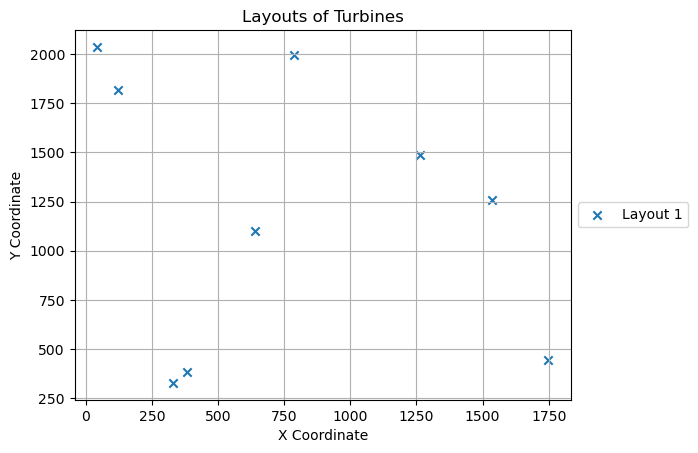

In [24]:
initial_layout = initial_population[0]
plot_multiple_layouts(initial_layout.reshape((1, n_turbines, 2)))

# Powell's method

In [25]:
def obj_function_to_minimize(solution):
    return -objective_function(solution)

In [26]:
def spacing_constraint(layout):
    layout = layout.reshape((n_turbines, 2))
    for i in range(n_turbines):
        for j in range(i + 1, n_turbines):
            distance = np.linalg.norm(layout[i] - layout[j])
            if distance < min_spacing:
                return distance - min_spacing
    return 0

constraints = {
    'type': 'ineq',
    'fun': spacing_constraint
}

def on_callback(X):
    global objective_values
    objective_values.append(-obj_function_to_minimize(X))

In [27]:
best_layouts = []
best_fitness_values = []
fitness_values = []


num_simulations = 1
for i in range(num_simulations):
    print("\nSIMULATION NO:", i+1)
    
    # initial_layout = np.random.uniform(
    #     low=0, high=area_size, size=(2*n_turbines)
    # )
    
    objective_values = []
    result = minimize(obj_function_to_minimize,
                      initial_layout,
                      method='Powell',
                      bounds=[(0.0, area_size)] * (2*n_turbines),
                      #constraints=constraints,
                      options={'disp': True},
                      callback=on_callback
                     )

    fitness_values.append(objective_values)
    optimal_layout = result.x.reshape((n_turbines, 2)).astype(int)
    optimal_fitness = -result.fun 
    best_layouts.append(optimal_layout)
    best_fitness_values.append(optimal_fitness)


SIMULATION NO: 1
Optimization terminated successfully.
         Current function value: -134.917683
         Iterations: 2
         Function evaluations: 975


Solution:	1
Valid:    	False
Total AEP:	134.918
Percent of valid solutions: 0.0 %


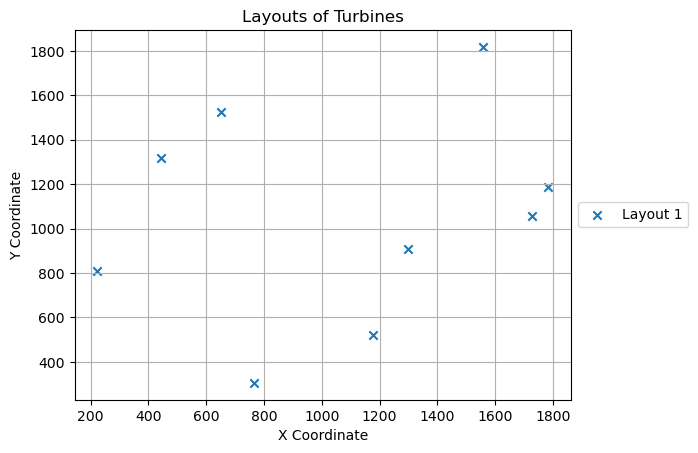

No valid solutions


In [28]:
print_metrics_for_multiple_layouts(best_layouts, best_fitness_values, max_val=301.82, area_limits=False, plot_score=False)

# GA

### Fitness function

In [36]:
def fitness_func(ga_instance, solution, solution_idx):
    return objective_function(solution)

### GA parameters

In [37]:
num_genes = 2 * n_turbines

num_generations = 50
num_parents_mating = 4
sol_per_pop = 100


init_range_low = 0
init_range_high = area_size
parent_selection_type = "sss"
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 20
stop_criteria = "saturate_10"

### GA loop

In [38]:
best_layouts = []
best_fitness_values = []
fitness_values = []


def on_generation_callback(ga_instance):
    best_solution_fitness = ga_instance.best_solution()[1]
    print(f"Generation {ga_instance.generations_completed}: Best Fitness: {best_solution_fitness}")



num_simulations = 1
for i in range(num_simulations):
    print("\nSIMULATION NO:", i+1)
    
    # initial_population = np.random.uniform(
    #     low=init_range_low, high=init_range_high, size=(sol_per_pop, num_genes)
    # )
    
    ga_instance = pygad.GA(
        initial_population=initial_population,
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_func,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        init_range_low=init_range_low,
        init_range_high=init_range_high,
        parent_selection_type=parent_selection_type,
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_percent_genes=mutation_percent_genes,
        stop_criteria=stop_criteria,
        on_generation=on_generation_callback,
        save_solutions=True,
        suppress_warnings=True
    )

    ga_instance.run()

    best_solution, best_solution_fitness, _ = ga_instance.best_solution()
    best_solution = best_solution.reshape((n_turbines, 2)).astype(int)
    
    best_layouts.append(best_solution)
    best_fitness_values.append(best_solution_fitness)
    fitness_values.append(ga_instance.best_solutions_fitness)


SIMULATION NO: 1
Generation 1: Best Fitness: 282.95816003407066
Generation 2: Best Fitness: 297.9687786512702
Generation 3: Best Fitness: 298.076161832016
Generation 4: Best Fitness: 298.1495732601445
Generation 5: Best Fitness: 298.3003145674787
Generation 6: Best Fitness: 298.46228320591314
Generation 7: Best Fitness: 298.6090321489298
Generation 8: Best Fitness: 298.69739832683433
Generation 9: Best Fitness: 298.79952355659236
Generation 10: Best Fitness: 298.9555319289085
Generation 11: Best Fitness: 299.0648704868581
Generation 12: Best Fitness: 299.1940852589453
Generation 13: Best Fitness: 299.2942711225297
Generation 14: Best Fitness: 299.36214826022456
Generation 15: Best Fitness: 299.47398067426377
Generation 16: Best Fitness: 299.5592098511622
Generation 17: Best Fitness: 299.7047559977268
Generation 18: Best Fitness: 299.84548760176847
Generation 19: Best Fitness: 299.9453293729536
Generation 20: Best Fitness: 300.03010932058555
Generation 21: Best Fitness: 300.15167793822

Solution:	1
Valid:    	True
Total AEP:	301.816
Percent of valid solutions: 100.0 %


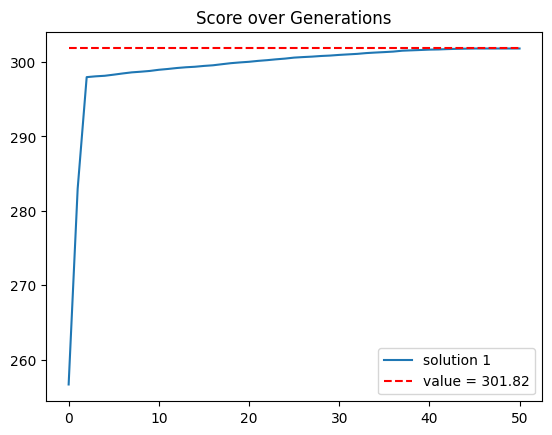

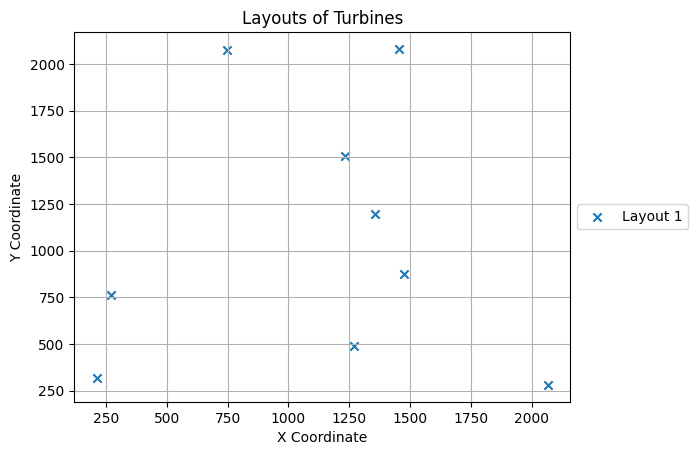

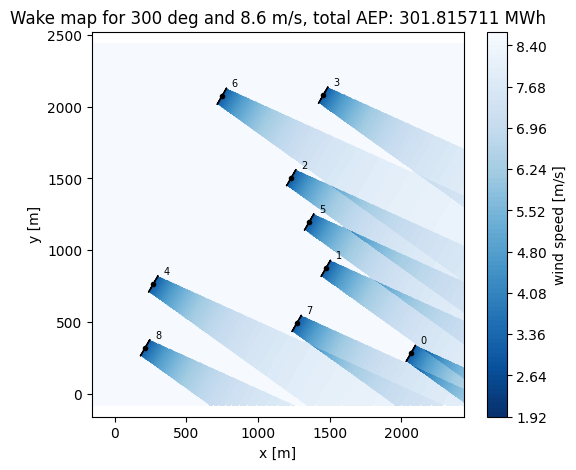

In [39]:
print_metrics_for_multiple_layouts(best_layouts, best_fitness_values, max_val=301.82, area_limits=False)

### Gene values

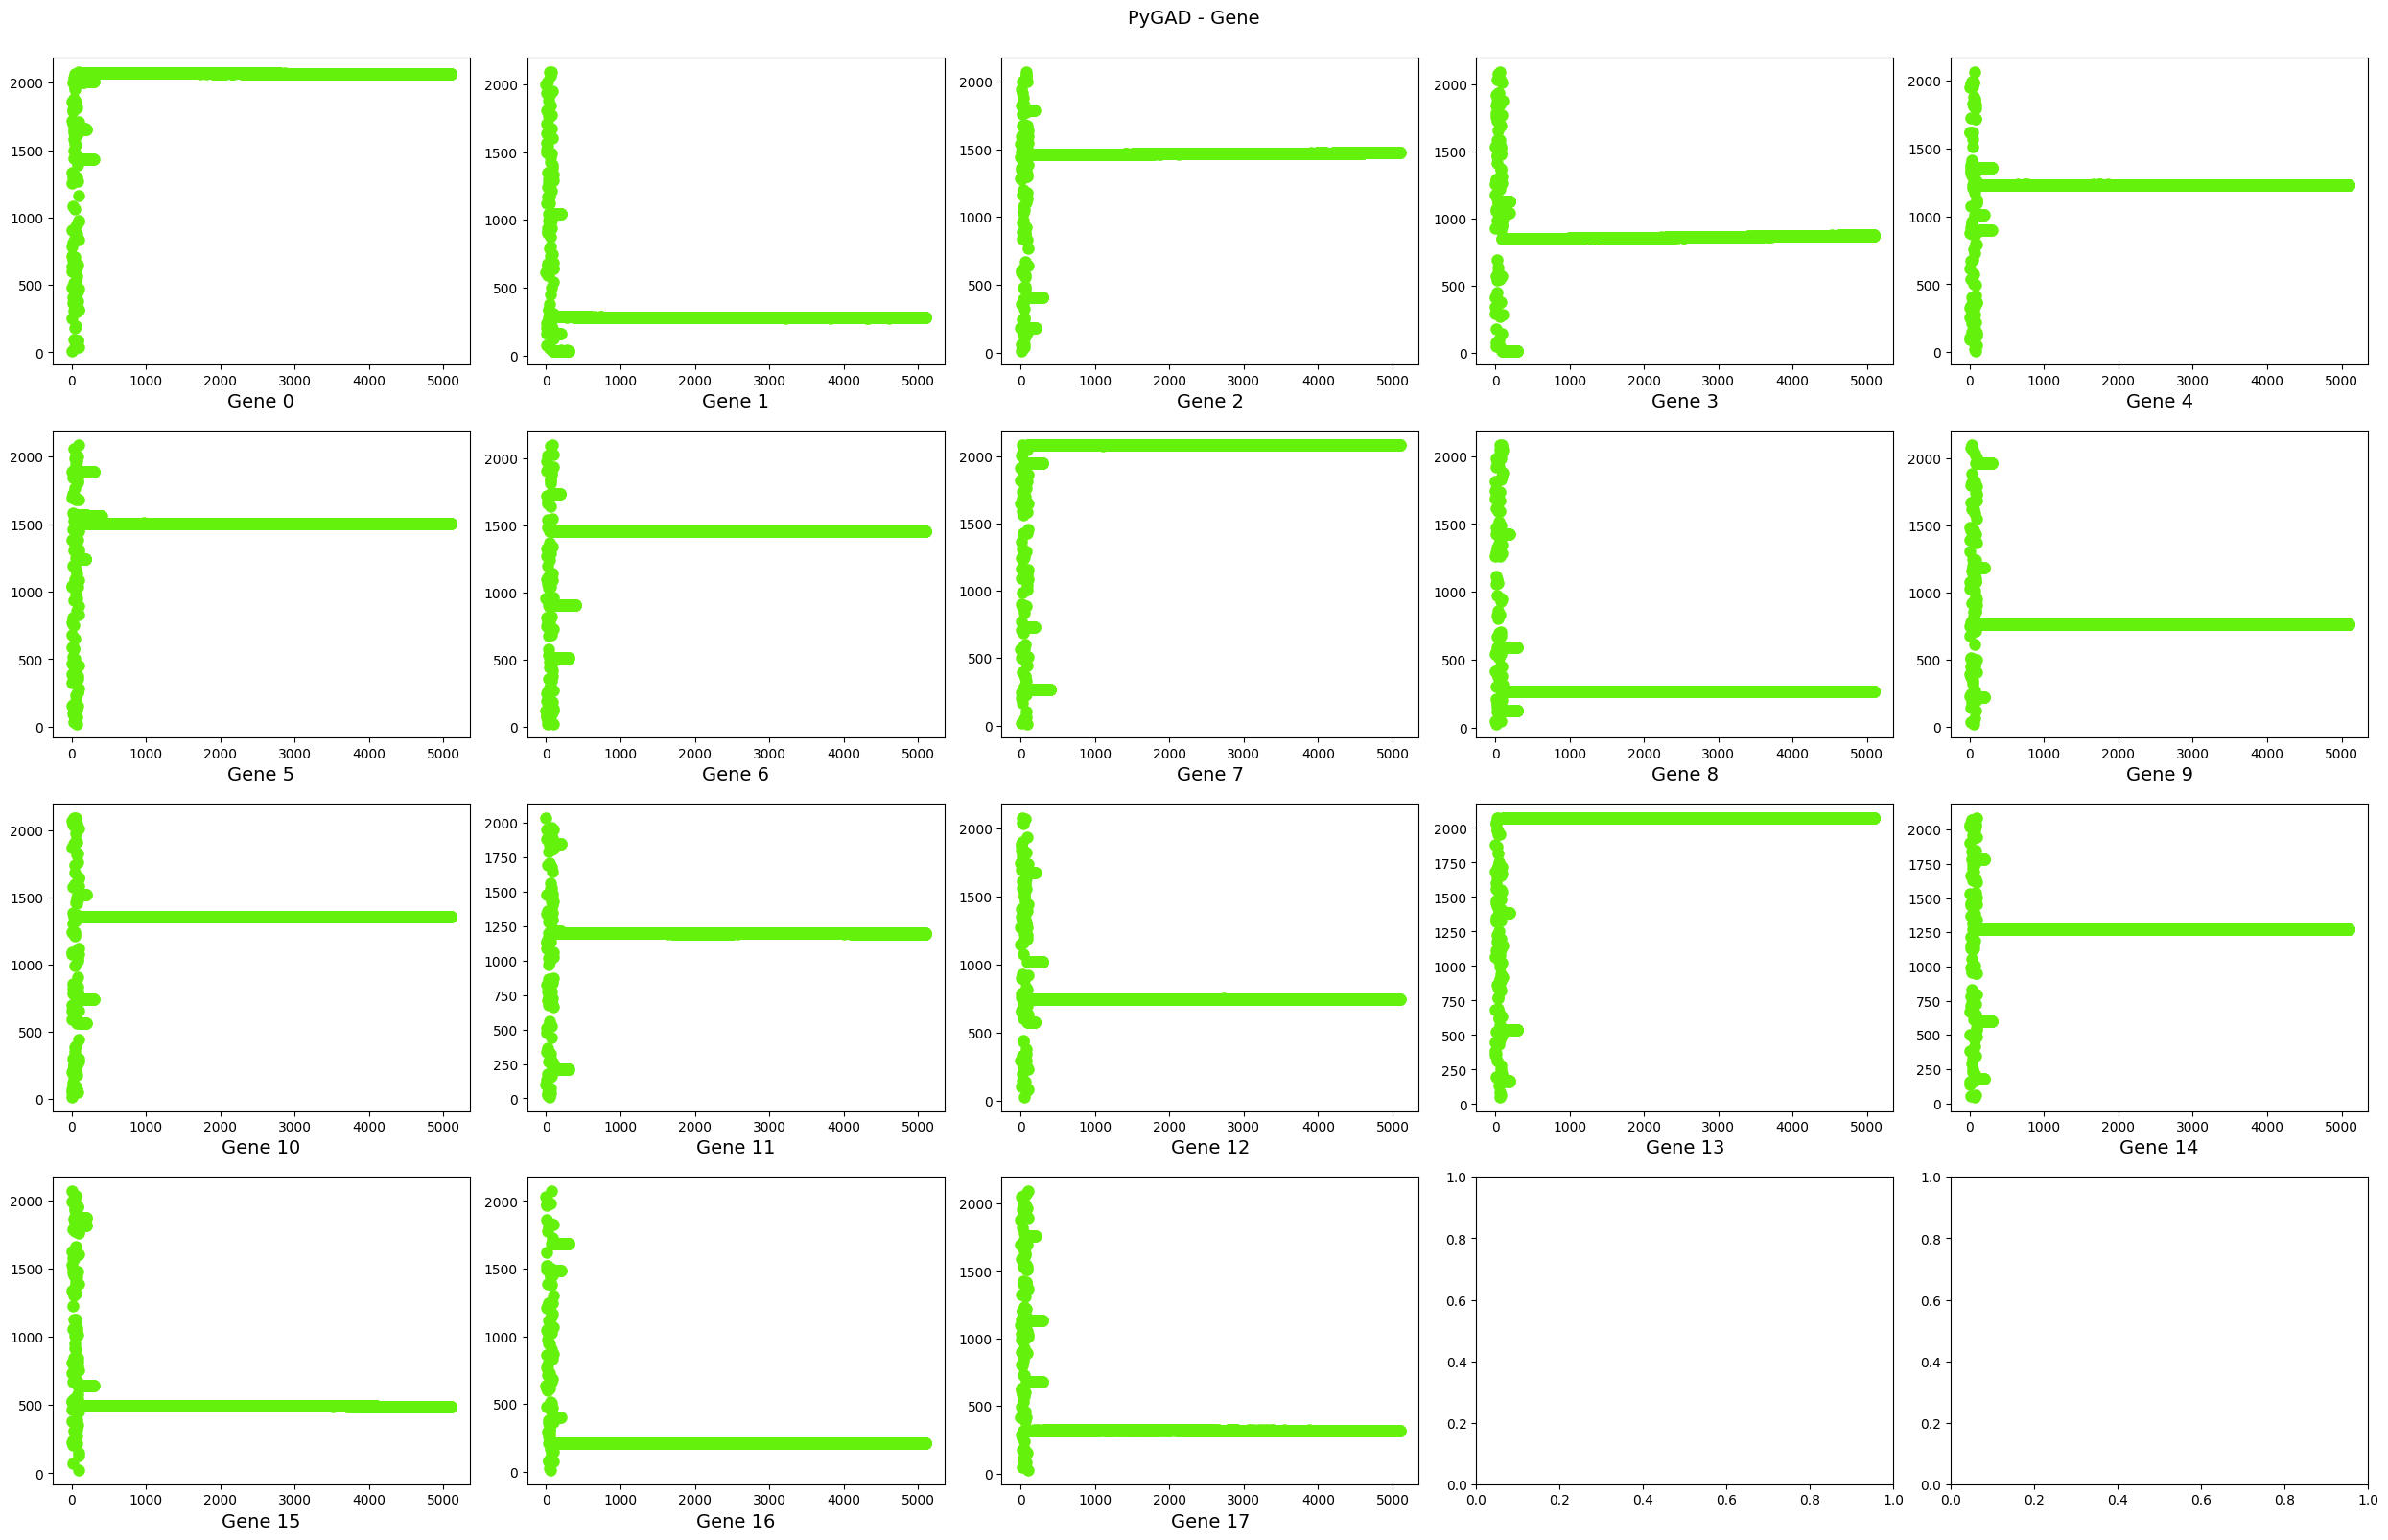

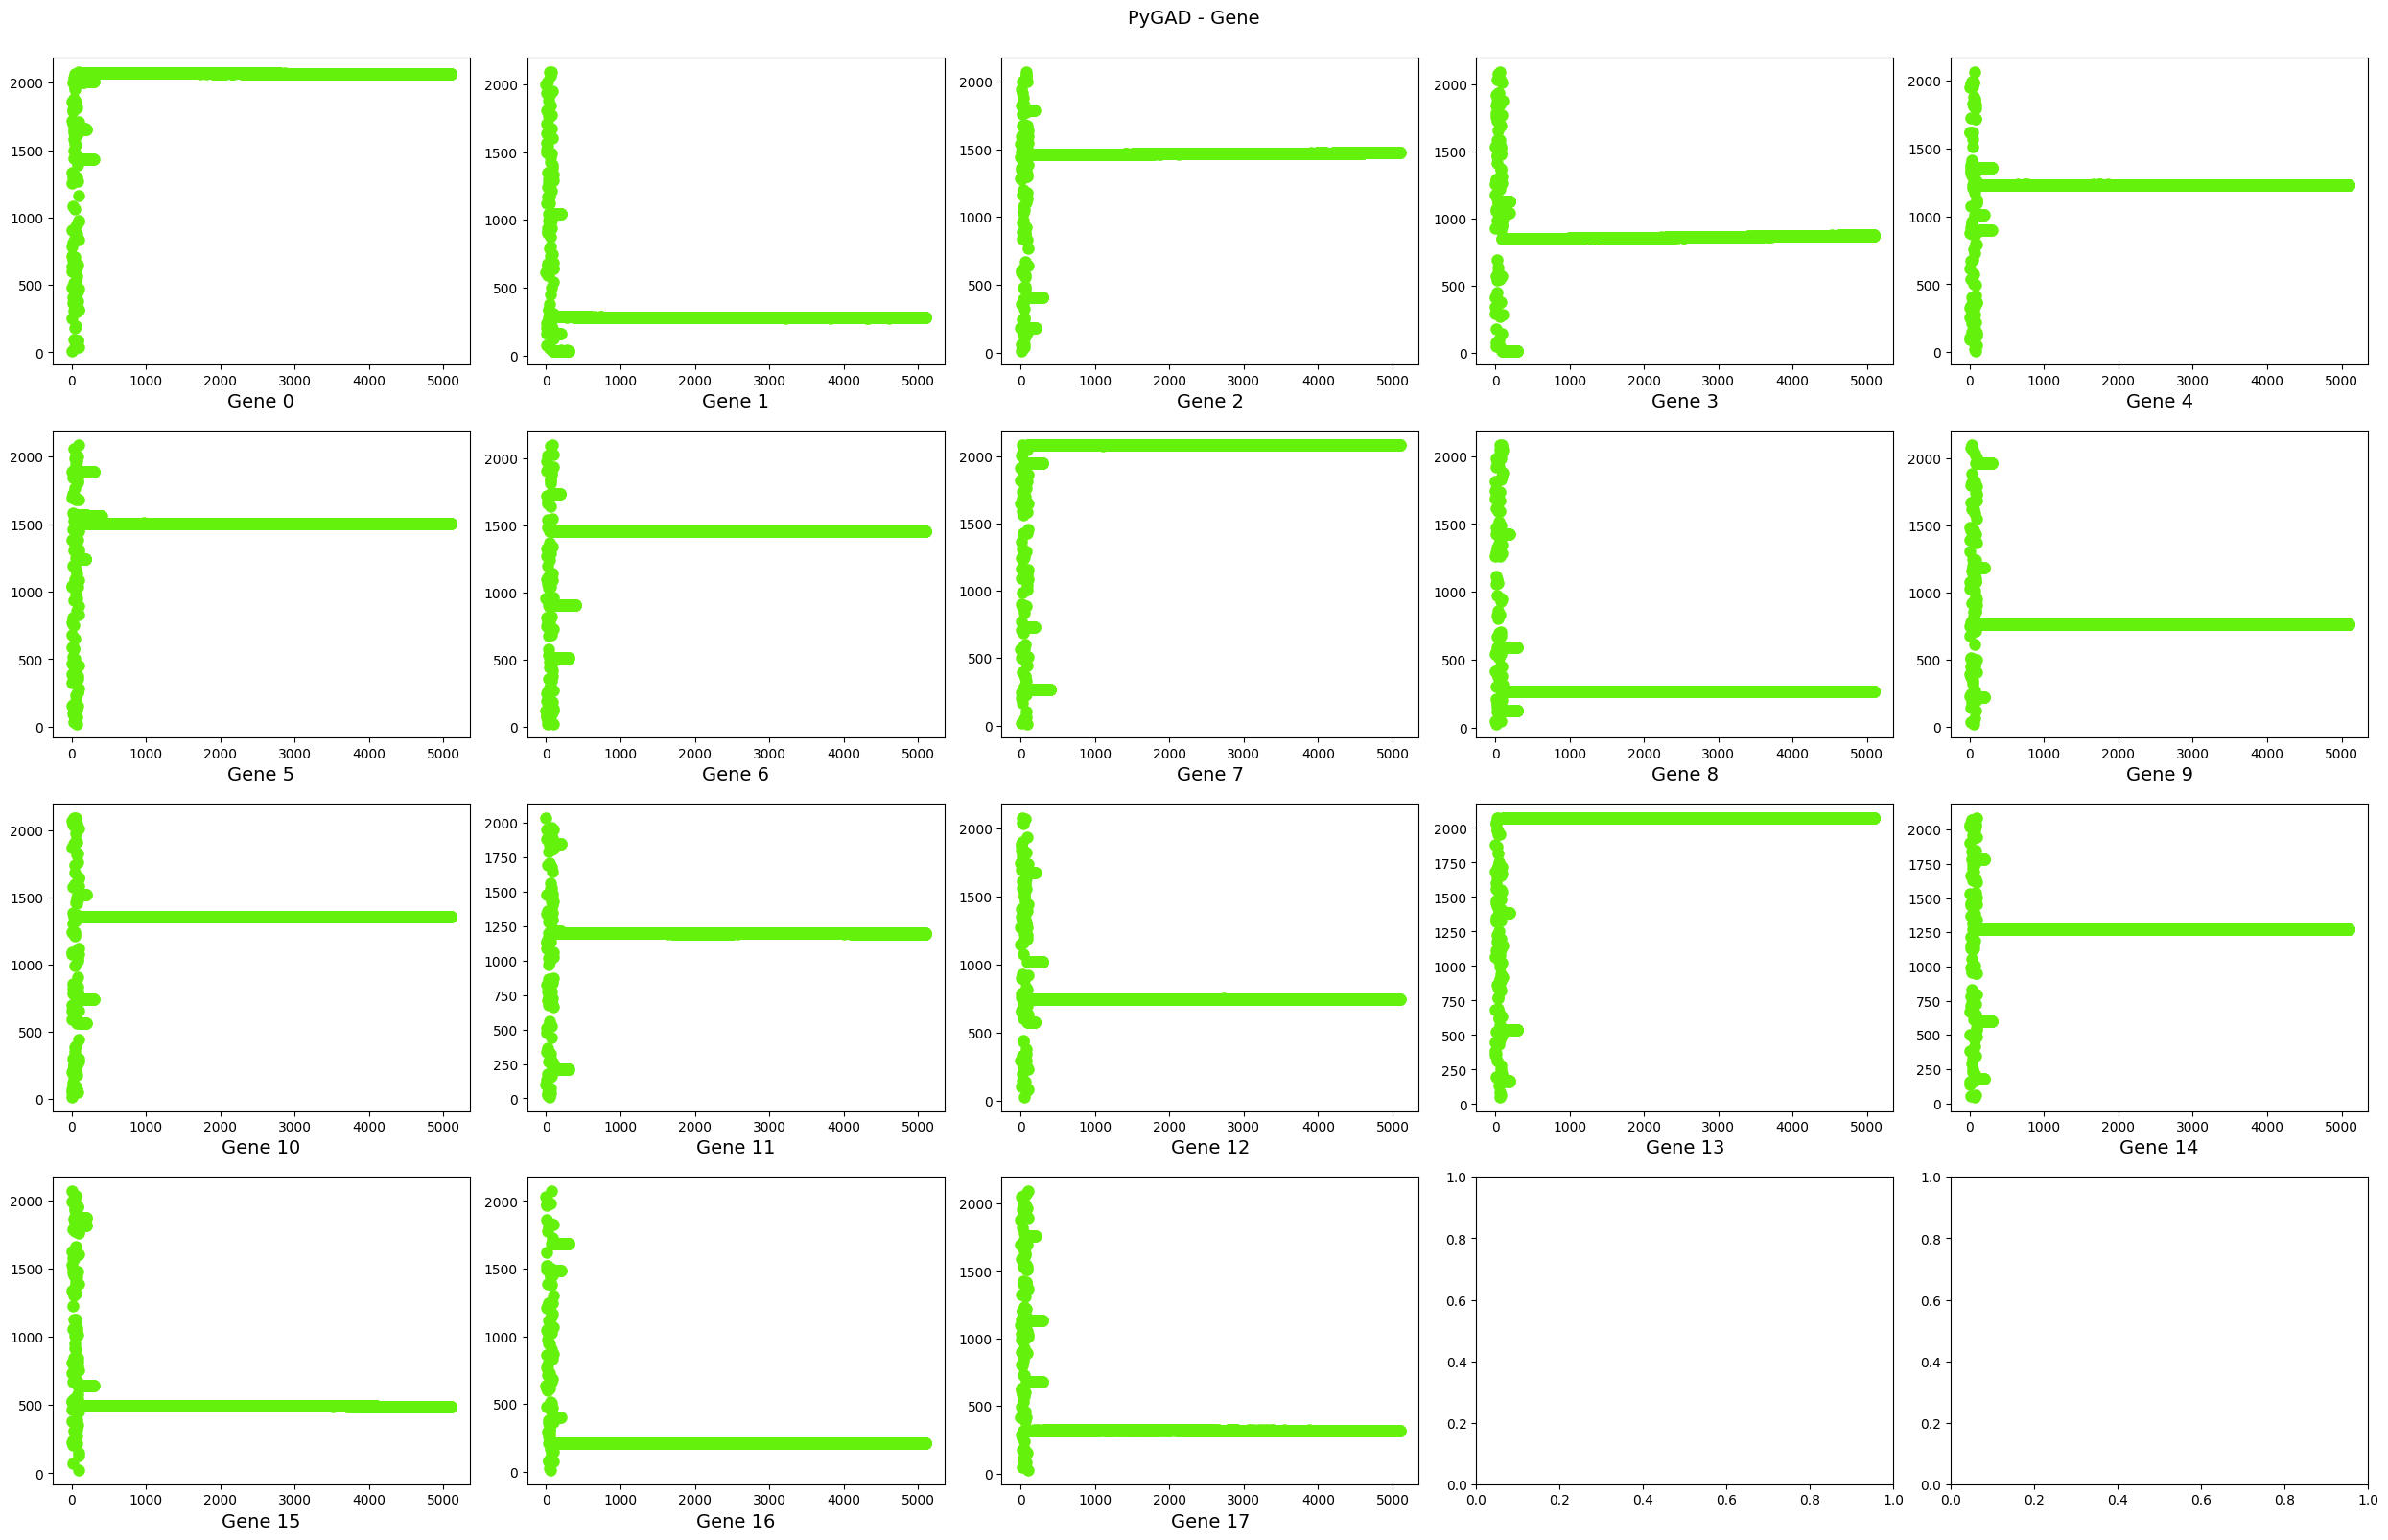

In [40]:
ga_instance.plot_genes(graph_type="plot",
                       plot_type="scatter",
                       solutions='all')

# ga_instance.plot_genes(graph_type="boxplot",
#                        solutions='all')
# ga_instance.plot_genes(graph_type="histogram",
#                        solutions='all')

### GAEstimator

In [63]:
class GAEstimator(BaseEstimator):
    def __init__(self, num_generations=100, num_parents_mating=2, sol_per_pop=100, 
                 parent_selection_type="sss", crossover_type="single_point",
                 mutation_type="random", mutation_probability=0.1, stop_criteria="saturate_10", fitness_func=fitness_func):
        self.best_solution_fitness = None
        self.best_solution = None
        self.num_generations = num_generations
        self.num_parents_mating = num_parents_mating
        self.sol_per_pop = sol_per_pop
        self.parent_selection_type = parent_selection_type
        self.crossover_type = crossover_type
        self.mutation_type = mutation_type
        self.mutation_probability = mutation_probability
        self.stop_criteria = stop_criteria

    def fit(self, X):
        initial_population = X

        self.ga_instance = pygad.GA(
            initial_population=initial_population,
            num_generations=self.num_generations,
            num_parents_mating=self.num_parents_mating,
            fitness_func=fitness_func,
            sol_per_pop=self.sol_per_pop,
            num_genes=len(initial_population),
            init_range_low=init_range_low,
            init_range_high=init_range_high,
            parent_selection_type=self.parent_selection_type,
            crossover_type=self.crossover_type,
            mutation_type=self.mutation_type,
            mutation_probability=self.mutation_probability,
            stop_criteria=self.stop_criteria,
            #on_generation=on_generation_callback,
            suppress_warnings=True,
            random_seed=42
        )

        self.ga_instance.run()

        self.best_solution, self.best_solution_fitness, _ = self.ga_instance.best_solution()
        self.best_solution = self.best_solution.reshape((n_turbines, 2)).astype(int)
        return self

    def score(self):
        return self.best_solution_fitness
    
    def get_solution(self):
        return self.best_solution

## Using grid search to find the best combinations of hyperparameters

In [42]:
# parent_selection_types = ["sss", "rws", "sus", "rank", "random", "tournament"]
# crossover_types = ["single_point", "two_points", "uniform", "scattered"]
# mutation_types = ["random", "swap", "inversion", "scramble", "adaptive"]

param_grid = {
    'num_generations': [15], # 50,100
    'num_parents_mating': [4, 6], # 2, 6, 8, 10,
    'sol_per_pop': [50],
    'parent_selection_type': ["rws", "sus", "rank"], # "sss", 
    'crossover_type': ["two_points"],# "single_point", "two_points", "uniform"],
    'mutation_type': ["swap", "scramble"],
    'mutation_probability': [0.2, 0.3],
    'stop_criteria': ["saturate_5"]
}

param_combinations = list(itertools.product(
    param_grid['num_generations'],
    param_grid['num_parents_mating'],
    param_grid['sol_per_pop'],
    param_grid['parent_selection_type'],
    param_grid['crossover_type'],
    param_grid['mutation_type'],
    param_grid['mutation_probability'],
    param_grid['stop_criteria']
))

In [45]:
best_score = -np.inf
best_params = None
best_estimator = None

print("started...")
for combination in param_combinations:
    num_generations, num_parents_mating, sol_per_pop, parent_selection_type, crossover_type, mutation_type, mutation_probability, stop_criteria = combination
    ga_estimator = GAEstimator(
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        sol_per_pop=sol_per_pop,
        parent_selection_type=parent_selection_type,
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_probability=mutation_probability,
        stop_criteria=stop_criteria
    )

    initial_population_fitness = max(fitness_func(None, layout, None) for layout in initial_population)
    ga_estimator.fit(initial_population)
    score = ga_estimator.score()
    score_improvement = aep_percentage_change(initial_population_fitness, score)

    logging.basicConfig(level=logging.INFO)
    logging.info(f"Parameters: {combination}, Score: {score}, Improvement: {score_improvement}")

    if score > best_score:
        best_score = score
        best_params = combination
        best_estimator = ga_estimator

print('-'*20)
print("Best parameters found: ", best_params)
print("Best score: ", best_score)

started...


INFO:root:Parameters: (15, 4, 50, 'rws', 'two_points', 'swap', 0.2, 'saturate_5'), Score: 299.57454685372034, Improvement: [ 0.167267   21.46421369]
INFO:root:Parameters: (15, 4, 50, 'rws', 'two_points', 'swap', 0.3, 'saturate_5'), Score: 299.57454685372034, Improvement: [ 0.167267   21.46421369]
INFO:root:Parameters: (15, 4, 50, 'rws', 'two_points', 'scramble', 0.2, 'saturate_5'), Score: 299.2831600521781, Improvement: [ 0.16613164 21.31852029]
INFO:root:Parameters: (15, 4, 50, 'rws', 'two_points', 'scramble', 0.3, 'saturate_5'), Score: 299.2831600521781, Improvement: [ 0.16613164 21.31852029]
INFO:root:Parameters: (15, 4, 50, 'sus', 'two_points', 'swap', 0.2, 'saturate_5'), Score: 301.81571088709103, Improvement: [ 0.17599951 22.58479571]
INFO:root:Parameters: (15, 4, 50, 'sus', 'two_points', 'swap', 0.3, 'saturate_5'), Score: 301.81571088709103, Improvement: [ 0.17599951 22.58479571]
INFO:root:Parameters: (15, 4, 50, 'sus', 'two_points', 'scramble', 0.2, 'saturate_5'), Score: 292.80

--------------------
Best parameters found:  (15, 4, 50, 'sus', 'two_points', 'swap', 0.2, 'saturate_5')
Best score:  301.81571088709103


## adaptive mutation

In [47]:
best_params

(15, 4, 50, 'sus', 'two_points', 'swap', 0.2, 'saturate_5')

Valid:    	 True
Total AEP:	 278.2935511114145
Improvement:	 [ 0.0843474  10.82371582]


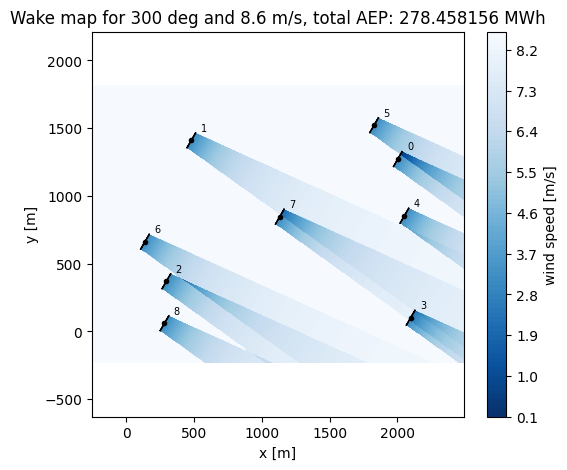

In [48]:
num_generations, num_parents_mating, sol_per_pop, parent_selection_type, crossover_type, mutation_type, mutation_probability, stop_criteria = best_params
num_generations = 10
sol_per_pop = 50
mutation_type ='adaptive'
mutation_probability = [0.2, 0.05]
stop_criteria = 'saturate_10'

ada_best_estimator = GAEstimator(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    sol_per_pop=sol_per_pop,
    parent_selection_type=parent_selection_type,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_probability=mutation_probability,
    stop_criteria=stop_criteria
)

ada_best_estimator.fit(initial_population)

best_fitness = ada_best_estimator.score()
best_layout = ada_best_estimator.get_solution()
initial_population_fitness = max(fitness_func(None, layout, None) for layout in initial_population)
score_improvement = aep_percentage_change(initial_population_fitness, best_fitness)

print('Valid:    \t', is_layout_valid(best_layout, area_size, min_spacing))
print('Total AEP:\t', best_fitness)
print('Improvement:\t', score_improvement)
x, y = best_layout.T.reshape((2, -1))
plot_wake_map(x,y)

# Initial population - worst case (for single wind direction)

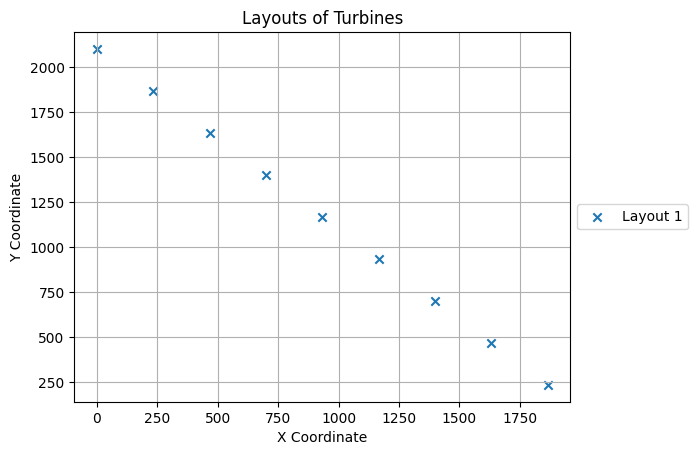

In [49]:
x_i, y_i = np.arange(n_turbines) * area_size/n_turbines, np.arange(n_turbines) * area_size/n_turbines

initial_layout = np.array([x_i, -y_i+area_size]).T.flatten()
plot_multiple_layouts(initial_layout.reshape((1, n_turbines, 2)))

initial_population = np.tile(initial_layout, (100, 1))

###  Powell's method

Optimization terminated successfully.
         Current function value: -271.436212
         Iterations: 2
         Function evaluations: 993
Solution:	1
Valid:    	True
Total AEP:	271.436
Percent of valid solutions: 100.0 %


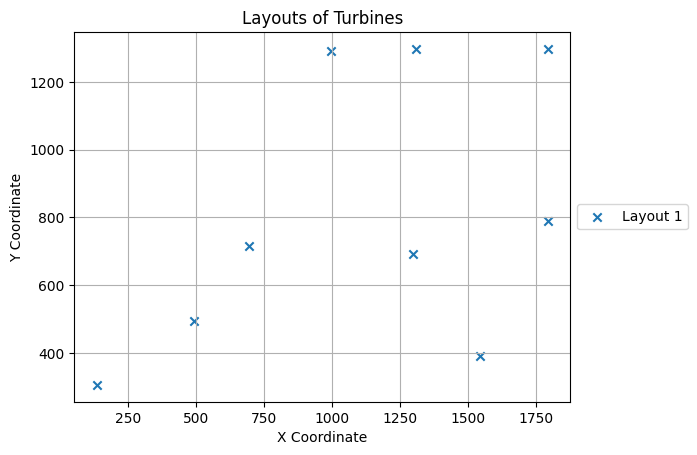

Valid:    	 True
Total AEP:	 271.4362118686968
AEP/MAX_AEP:	 89.93314288937007


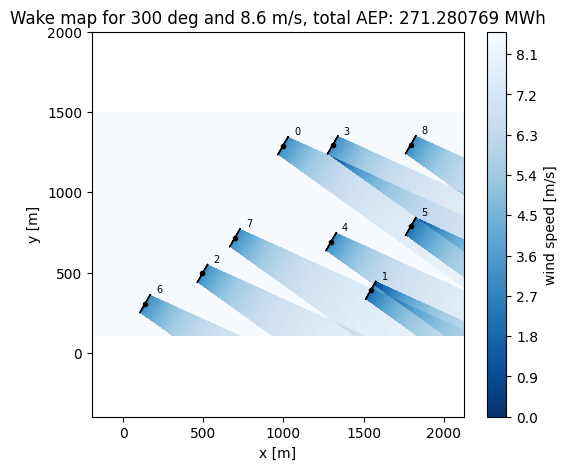

In [50]:
best_layouts = []
best_fitness_values = []
fitness_values = []

objective_values = []
result = minimize(obj_function_to_minimize,
                  initial_layout,
                  method='Powell',
                  bounds=[(0.0, area_size)] * (2*n_turbines),
                  options={'disp': True,
                           # 'maxiter':10
                          },
                  callback=on_callback
                 )

fitness_values.append(objective_values)
optimal_layout = result.x.reshape((n_turbines, 2)).astype(int)
optimal_fitness = -result.fun 

print_metrics_for_multiple_layouts([optimal_layout], [optimal_fitness], max_val=301.82, area_limits=False, plot_score=False)
print('Valid:    \t', is_layout_valid(optimal_layout, area_size, min_spacing))
print('Total AEP:\t', optimal_fitness)
print('AEP/MAX_AEP:\t', optimal_fitness/301.82 * 100)

### GA method

In [51]:
best_params

(15, 4, 50, 'sus', 'two_points', 'swap', 0.2, 'saturate_5')

Valid:    	 True
Total AEP:	 294.105696884357
AEP/MAX_AEP:	 97.44407159378338


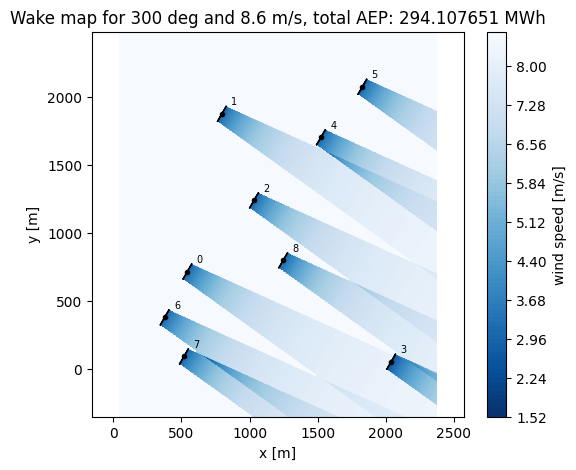

In [52]:
num_generations, num_parents_mating, sol_per_pop, parent_selection_type, crossover_type, mutation_type, mutation_probability, stop_criteria = best_params
num_generations = 50
sol_per_pop = 100
stop_criteria = 'saturate_10'

best_estimator = GAEstimator(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    sol_per_pop=sol_per_pop,
    parent_selection_type=parent_selection_type,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_probability=mutation_probability,
    stop_criteria=stop_criteria
)

best_estimator.fit(initial_population)
best_fitness = ga_estimator.score()
best_layout = ga_estimator.get_solution()

print('Valid:    \t', is_layout_valid(best_layout, area_size, min_spacing))
print('Total AEP:\t', best_fitness)
print('AEP/MAX_AEP:\t', best_fitness/301.82 * 100)
x, y = best_layout.T.reshape((2, -1))
plot_wake_map(x,y)

# Powell method - multiple random initial layouts

In [29]:
best_layouts = []
best_fitness_values = []
fitness_values = []


num_simulations = 100
for i in range(num_simulations):
    print("\nSIMULATION NO:", i+1)
    
    initial_layout = np.random.uniform(
        low=0, high=area_size, size=(2*n_turbines)
    )
    
    objective_values = []
    result = minimize(obj_function_to_minimize,
                      initial_layout,
                      method='Powell',
                      bounds=[(0.0, area_size)] * (2*n_turbines),
                      options={'disp': True,
                               'maxiter':10
                              },
                      callback=on_callback
                     )

    fitness_values.append(objective_values)
    optimal_layout = result.x.reshape((n_turbines, 2)).astype(int)
    optimal_fitness = -result.fun 
    best_layouts.append(optimal_layout)
    best_fitness_values.append(optimal_fitness)


SIMULATION NO: 1
Optimization terminated successfully.
         Current function value: -271.263781
         Iterations: 7
         Function evaluations: 3366

SIMULATION NO: 2
Optimization terminated successfully.
         Current function value: -140.692392
         Iterations: 3
         Function evaluations: 1505

SIMULATION NO: 3
Optimization terminated successfully.
         Current function value: -126.433826
         Iterations: 1
         Function evaluations: 490

SIMULATION NO: 4
Optimization terminated successfully.
         Current function value: -141.621640
         Iterations: 4
         Function evaluations: 1923

SIMULATION NO: 5
Optimization terminated successfully.
         Current function value: -141.916082
         Iterations: 3
         Function evaluations: 1576

SIMULATION NO: 6
Optimization terminated successfully.
         Current function value: -140.447121
         Iterations: 4
         Function evaluations: 1935

SIMULATION NO: 7
Optimization terminated

Solution:	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100
Valid:    	True	False	False	False	False	False	True	False	False	False	False	False	False	True	False	False	False	False	True	False	False	False	False	True	True	True	False	False	False	False	False	True	True	False	False	False	False	False	False	True	False	False	False	False	True	False	False	False	False	False	False	False	True	False	False	False	False	False	False	False	False	False	False	True	False	False	False	False	False	True	False	True	False	False	False	True	False	False	True	False	False	False	False	False	False	False	True	False	False	True	False	True	False	False	False	True	False	False	False	False
Total AEP:	271.264	140.692	126.434	141.622	141.916	140.447	254.735	140.795	138.728	139.462	136.036	141.533	1

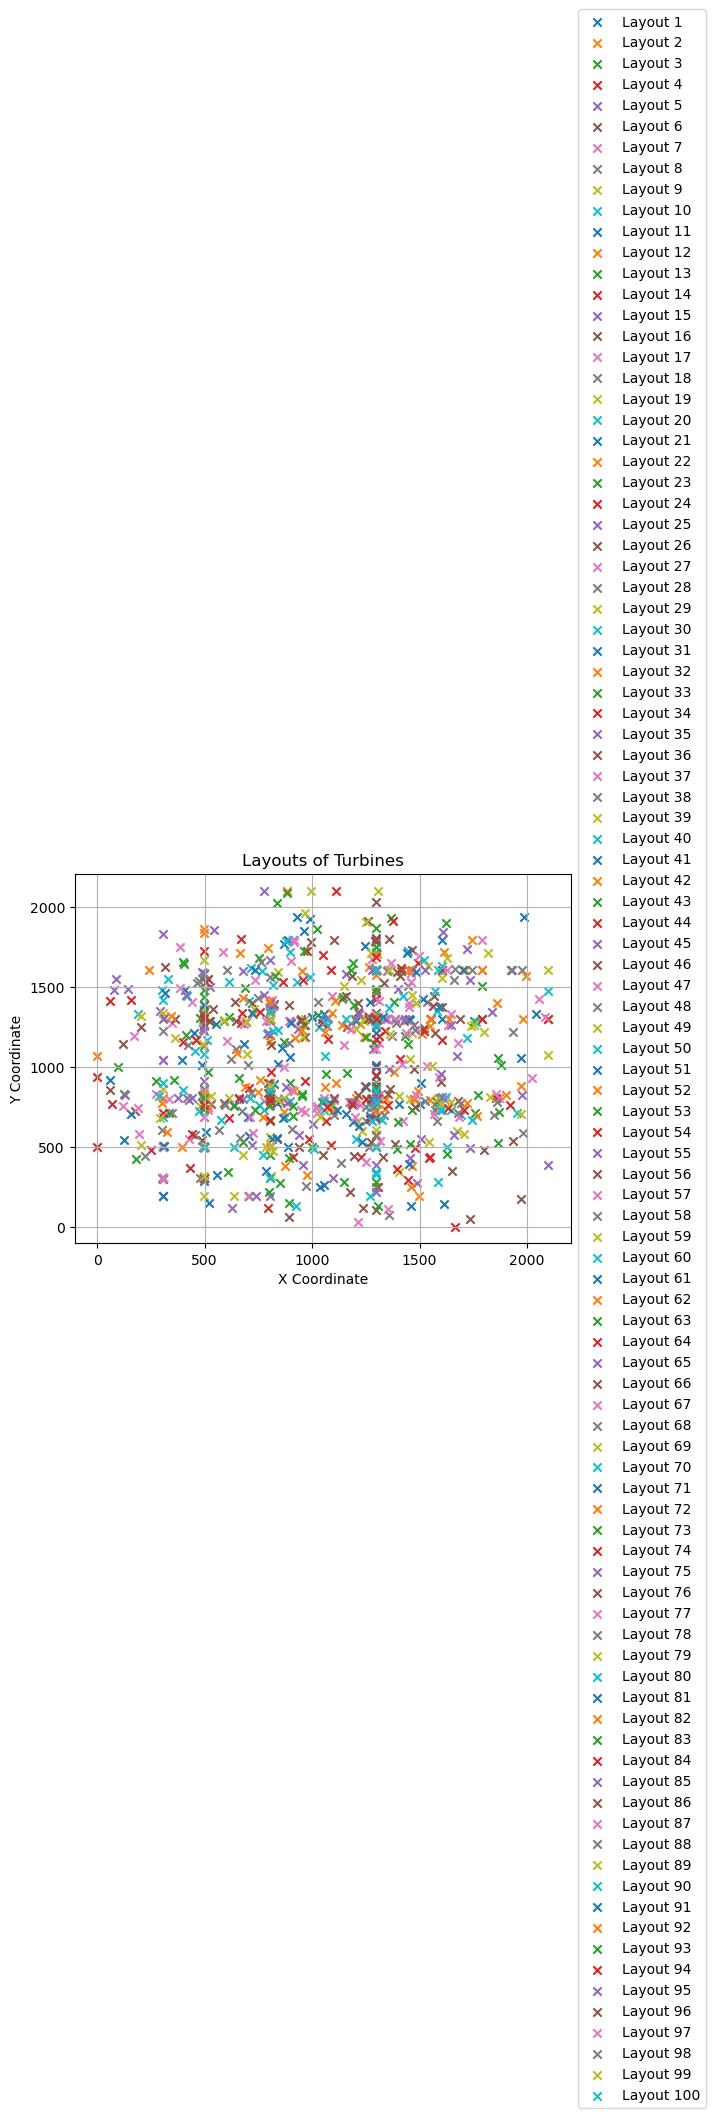

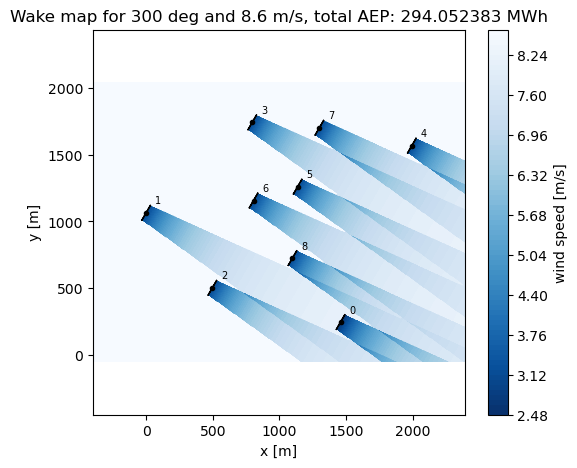

In [30]:
print_metrics_for_multiple_layouts(best_layouts, best_fitness_values, max_val=301.82, area_limits=False, plot_score=False)

# All wind directions case

In [55]:
def objective_function_2(solution):  # -> maximize
    wt_x, wt_y = solution.reshape((2, -1), order='F')
    # x, y = np.array(wt_x).astype(int), np.array(wt_y).astype(int)   # integer programming problem
    x, y = np.array(wt_x), np.array(wt_y)                           # non integer programming problem

    try:
        sim_res = wake_model(x, y, type=types, ws=[wind_speed], wd=wind_directions)   # all wind directions
        aep = sim_res.aep().sum()
    except:
        return 0

    valid = is_layout_valid(solution.reshape((-1, 2)), area_size, min_spacing)
    
    return float(aep.values) * (0.5 if not valid else 1)

## Powell's method

In [56]:
def obj_function_to_minimize_2(solution):
    return -objective_function_2(solution)

In [57]:
best_layouts = []
best_fitness_values = []
fitness_values = []


num_simulations = 10
for i in range(num_simulations):
    print("\nSIMULATION NO:", i+1)
    
    initial_layout = np.random.uniform(
        low=0, high=area_size, size=(2*n_turbines)
    )
    
    objective_values = []
    result = minimize(obj_function_to_minimize_2,
                      initial_layout,
                      method='Powell',
                      bounds=[(0.0, area_size)] * (2*n_turbines),
                      options={'disp': True,
                               'maxiter':10
                              },
                      callback=on_callback
                     )

    fitness_values.append(objective_values)
    optimal_layout = result.x.reshape((n_turbines, 2)).astype(int)
    optimal_fitness = -result.fun 
    best_layouts.append(optimal_layout)
    best_fitness_values.append(optimal_fitness)


SIMULATION NO: 1
Optimization terminated successfully.
         Current function value: -53.295382
         Iterations: 2
         Function evaluations: 719

SIMULATION NO: 2
Optimization terminated successfully.
         Current function value: -107.539613
         Iterations: 4
         Function evaluations: 1249

SIMULATION NO: 3
Optimization terminated successfully.
         Current function value: -106.526631
         Iterations: 3
         Function evaluations: 1085

SIMULATION NO: 4
Optimization terminated successfully.
         Current function value: -108.660966
         Iterations: 2
         Function evaluations: 740

SIMULATION NO: 5
Optimization terminated successfully.
         Current function value: -109.556947
         Iterations: 4
         Function evaluations: 1395

SIMULATION NO: 6
Optimization terminated successfully.
         Current function value: -109.439474
         Iterations: 3
         Function evaluations: 1002

SIMULATION NO: 7
Optimization terminated s

Solution:	1	2	3	4	5	6	7	8	9	10
Valid:    	False	True	True	True	True	True	True	False	True	False
Total AEP:	53.295	107.54	106.527	108.661	109.557	109.439	109.152	105.171	104.839	50.455
Percent of valid solutions: 70.0 %


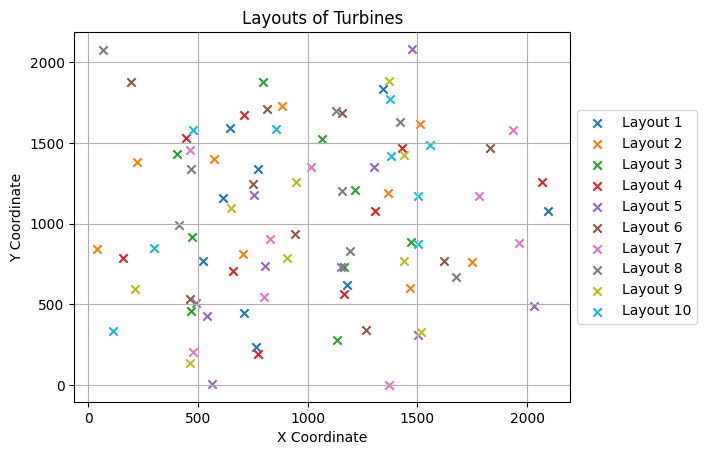

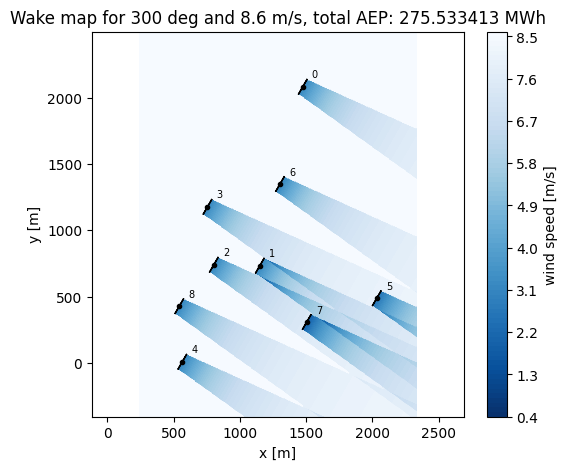

In [58]:
print_metrics_for_multiple_layouts(best_layouts, best_fitness_values, area_limits=False, plot_score=False)

## GA

In [62]:
def fitness_func_2(ga_instance, solution, solution_idx):
    return objective_function_2(solution)

In [59]:
best_params

(15, 4, 50, 'sus', 'two_points', 'swap', 0.2, 'saturate_5')

Valid:    	 True
Total AEP:	 294.105696884357


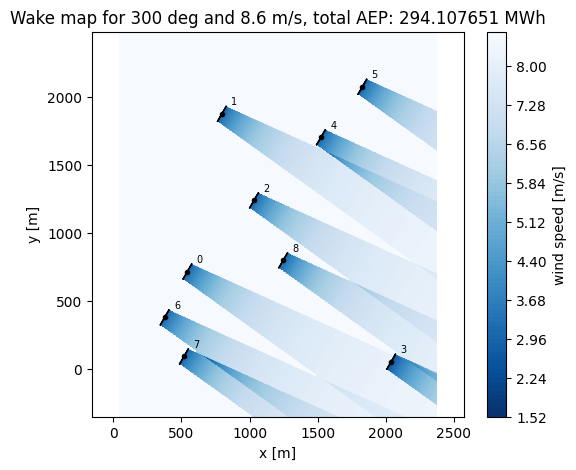

In [64]:
num_generations, num_parents_mating, sol_per_pop, parent_selection_type, crossover_type, mutation_type, mutation_probability, stop_criteria = best_params
num_generations = 50
sol_per_pop = 100
stop_criteria = 'saturate_10'

best_estimator = GAEstimator(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    sol_per_pop=sol_per_pop,
    parent_selection_type=parent_selection_type,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_probability=mutation_probability,
    stop_criteria=stop_criteria,
    fitness_func=fitness_func_2
)

best_estimator.fit(initial_population)
best_fitness = ga_estimator.score()
best_layout = ga_estimator.get_solution()

print('Valid:    \t', is_layout_valid(best_layout, area_size, min_spacing))
print('Total AEP:\t', best_fitness)
x, y = best_layout.T.reshape((2, -1))
plot_wake_map(x,y)